$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Weather Crime Investigation using Dr. Anderson's SCD NNs

## *Amber Lee*

### Overview:

### Investigation of various hidden layer structures on newly weekly aggregated weather/crime data

*NOTE- Not all parts of this investigation are documented here.  For example, while looking for various hidden structures, I tried various number of weather inputs.   The best correlations were found using avg bulb temp, dew pt, and humidity.  Wind speed seems to add noise to the model.*

## Required Code

Download [nn2.tar](http://www.cs.colostate.edu/~anderson/cs440/notebooks/nn2.tar) that was used in lecture and extract its contents, which are

* `neuralnetworks.py`
* `scaledconjugategradient.py`
* `mlutils.py`

In [1]:
import mlutils as ml
import neuralnetworks as nn
import scaledconjugategradient as sc
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint 
import time

### trainNNs
The trainNNs function was fairly straightforward and follows the outlined algorithm that Dr. Anderson provided.  The trickiest part was figuring out how to pass the number of elements in T to the Classifier constructor.   len(np.unique(T)) worked well to solve this.   We used RMSE to calculate performance on the linear network and a sum of the fraction of errors for the classification network.

In [2]:
def trainNNs(X, T, trainFraction, hiddenLayerStructures, numberRepetitions, numberIterations, classify=False):
    result = []
    
    for hidden in hiddenLayerStructures:
        
        train_performance = []
        test_performance = []
        total_collection = []
        
        start_time = time.time()
        
        for n in range(numberRepetitions):
            
            Xtrain, Ttrain, Xtest, Ttest = ml.partition(X, T, (trainFraction, 1-trainFraction), classify)
            
            if classify:
                
                nnet = nn.NeuralNetworkClassifier(X.shape[1], hidden, len(np.unique(T))) #need to calculate output layer
                nnet.train(Xtrain, Ttrain, numberIterations)
                
                Ytrain = nnet.use(Xtrain)
                Ytest = nnet.use(Xtest)
                
                train_performance.append((np.sum(Ytrain != Ttrain)/len(Ttrain)))
                test_performance.append((np.sum(Ytest != Ttest)/len(Ttest)))

            else:
                nnet = nn.NeuralNetwork(X.shape[1], hidden, T.shape[1])
                nnet.train(Xtrain, Ttrain, numberIterations)
            
                Ytrain = nnet.use(Xtrain)
                Ytest = nnet.use(Xtest)
                
                train_performance.append(np.sqrt(np.mean((Ytrain-Ttrain)**2)))
                test_performance.append(np.sqrt(np.mean((Ytest-Ttest)**2)))
            
        end_time = time.time()
        total_time = end_time - start_time
            
        total_collection.append(hidden) 
        total_collection.append(train_performance)
        total_collection.append(test_performance)
        total_collection.append(total_time)
            
        result.append(total_collection)
        
    return result

In [3]:
def summarize(results):
    summary = []
    
    for structure in results:
        structure_summary = []
        
        for index, value in enumerate(structure):
            if (index == 0): #hidden layer
                structure_summary.append(value)
            elif (index == 3): #total time
                structure_summary.append(value)
            #the first time we hit this else we are averaging train error
            #the second time we are averaging test error
            else:
                total = 0
                for rmse in value:
                    total += rmse
                structure_summary.append(total/len(value))
        
        summary.append(structure_summary)
    
    return summary

In [4]:
def bestNetwork(summary):          
    #google search for a cool python solution led me to this tutorial. 
    #https://dbader.org/blog/python-min-max-and-nested-lists
    #python is rad
    return min(summary, key=lambda x: x[2])

In [25]:
def plotResults(district, hidden, numIters):
    
    print('DISTRICT {}'.format(district))
    print('Hidden Layer Structure: {0} Number Iterations: {1}'.format(hidden, numIters))

    plt.figure(figsize = (8, 5))
    axes = plt.gca()
    #axes.set_xlim(None, 10)
    #axes.set_ylim(None, 10)
    plt.scatter(Ttest[:,0], Ytest_3000[:,0], alpha=0.25)
    plt.plot([0,300], [0,300], 'r', linewidth=2)
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title('Homicide Actual vs Predicted')
    plt.show();

    plt.figure(figsize = (8, 5))
    axes = plt.gca()
    #axes.set_xlim(None, 35)
    #axes.set_ylim(None, 35)
    plt.scatter(Ttest[:,1], Ytest_3000[:,1], alpha=0.25)
    plt.plot([0,200], [0,200], 'r', linewidth=2)
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title('Robbery Actual vs Predicted')
    plt.show();

    plt.figure(figsize = (8, 5))
    #axes = plt.gca()
    #axes.set_xlim(None, 100)
    axes.set_ylim(None, 100)
    plt.scatter(Ttest[:,2], Ytest_3000[:,2], alpha=0.25)
    plt.plot([0,500], [0,500], 'r', linewidth=2)
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title('Battery Actual vs Predicted')
    plt.show();

    plt.figure(figsize = (8, 5))
    axes = plt.gca()
    #axes.set_xlim(None, 40)
    #axes.set_ylim(None, 40)
    plt.scatter(Ttest[:,3], Ytest_3000[:,3], alpha=0.25)
    plt.plot([0,200], [0,200], 'r', linewidth=2)
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title('ASSAULT Actual vs Predicted')
    plt.show();

    plt.figure(figsize = (8, 5))
    axes = plt.gca()
    #axes.set_xlim(None, 40)
    #axes.set_ylim(None, 40)
    plt.scatter(Ttest[:,4], Ytest_3000[:,4], alpha=0.25)
    plt.plot([0,200], [0,200], 'r', linewidth=2)
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title('BURGLARY Actual vs Predicted')
    plt.show();

    plt.figure(figsize = (8, 5))
    axes = plt.gca()
    #axes.set_xlim(None, 80)
    #axes.set_ylim(None, 80)
    plt.scatter(Ttest[:,5], Ytest_3000[:,5], alpha=0.25)
    plt.plot([0,300], [0,300], 'r', linewidth=2)
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title('Theft Actual vs Predicted')
    plt.show();

    plt.figure(figsize = (8, 5))
    axes = plt.gca()
    #axes.set_xlim(None, 30)
    #axes.set_ylim(None, 30)
    plt.scatter(Ttest[:,6], Ytest_3000[:,6], alpha=0.25)
    plt.plot([0,200], [0,200], 'r', linewidth=2)
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title('MOTOR VEHICLE THEFT Actual vs Predicted')
    plt.show();

    plt.figure(figsize = (8, 5))
    axes = plt.gca()
    #axes.set_xlim(None, 10)
    #axes.set_ylim(None, 10)
    plt.scatter(Ttest[:,7], Ytest_3000[:,7], alpha=0.25)
    plt.plot([0,200], [0,200], 'r', linewidth=2)
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title('WEAPONS VIOLATION Actual vs Predicted')
    plt.show();

    plt.figure(figsize = (10, 10))
    axes = plt.gca()
    #axes.set_xlim(0, 300)
    #axes.set_ylim(0, 300)
    plt.scatter(Ttest[:,0], Ytest_3000[:,0], alpha=0.50, label= 'Homicide')
    plt.scatter(Ttest[:,1], Ytest_3000[:,1], alpha=0.50, label= 'Battery')
    plt.scatter(Ttest[:,3], Ytest_3000[:,3], alpha=0.50, label= 'Assault')
    plt.scatter(Ttest[:,4], Ytest_3000[:,4], alpha=0.50, label= 'Burglary')
    plt.scatter(Ttest[:,5], Ytest_3000[:,5], alpha=0.50, label= 'Theft')
    plt.scatter(Ttest[:,6], Ytest_3000[:,6], alpha=0.50, label= 'MotorVehicleTheft')
    plt.scatter(Ttest[:,7], Ytest_3000[:,7], alpha=0.50, label= 'Weapons Violation')

    plt.plot([0,300], [0,300], 'r', linewidth=1)
    plt.legend()
    plt.show();

In [6]:
def loadWeatherData(file, numWeatherInputs):
    
    f = open(file, "r")
    
    data = np.loadtxt(f, delimiter=',', usecols=1+np.arange(13))
    
    targetColumns = np.arange(5, 13)
    
    if (numWeatherInputs != 3):
        XColumns = np.arange(numWeatherInputs)
    
    else:
        XColumns = np.array([0,1,3])
    
    X = data[:,XColumns]
    
    T = data[:,targetColumns]
    
    return X, T

In [7]:
Xw5, Tc5 = loadWeatherData("5.csv", 3)

In [8]:
Xw5.shape, Tc5.shape

((810, 3), (810, 8))

In [9]:
Xw5[:2]

array([[23.78797144, 18.09991126, 79.14197783],
       [44.10028289, 32.06690432, 79.47471293]])

In [10]:
Tc5[:2]

array([[ 1.,  0.,  0.,  0.,  0.,  6.,  8.,  0.],
       [ 4.,  0., 17., 13.,  0.,  7.,  8.,  5.]])

#### Choose various hidden layer models to see how they perform on our data.   Here I'm chosing a linear function (zero), and varying numbers of units and layers combinations.   

In [11]:
hiddenLayers = [0, 5, 15, [5, 5], [10, 10], [15, 15], [10, 10, 10], [20, 20, 20]]

In [12]:
def errorTracePlt(X, T, trainFraction, hidden, numberIterations, classify):

    nnet = nn.NeuralNetwork(X.shape[1], hidden, T.shape[1])
    nnet.train(X, T, numberIterations)

    plt.plot(nnet.getErrorTrace(), label=hidden)
    plt.xlabel('Iteration')
    plt.ylabel('Error')
    
    plt.legend()
    plt.show()
    

In [13]:
def testLayerStructures(X, T, hiddenLayers, numIters):
    for hidden in hiddenLayers:
        errorTracePlt(X, T, 0.8, hidden, numIters, False)

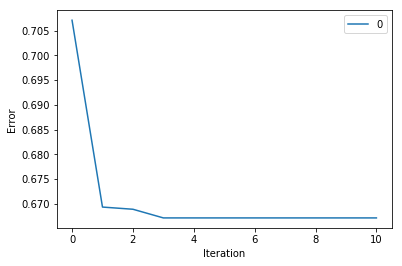

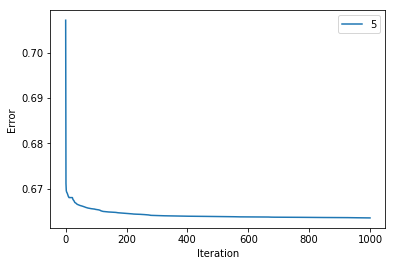

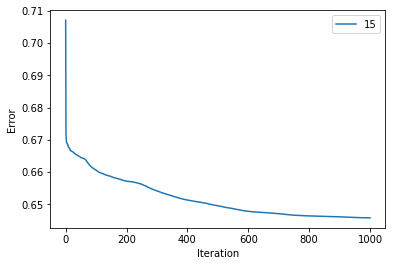

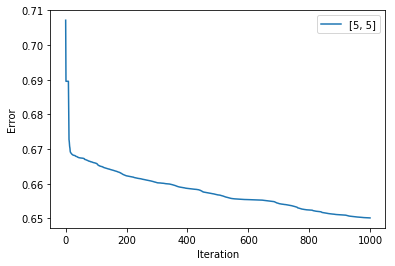

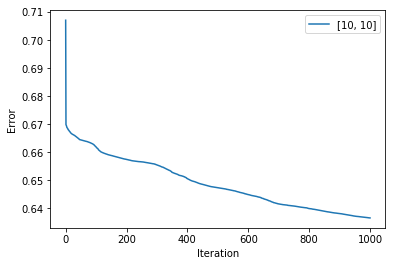

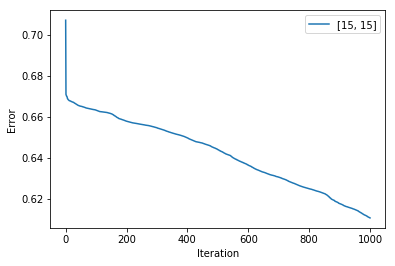

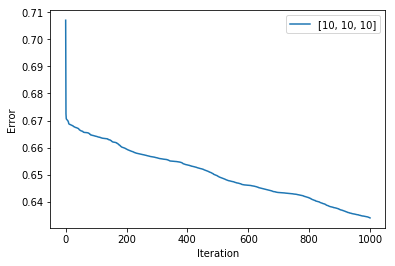

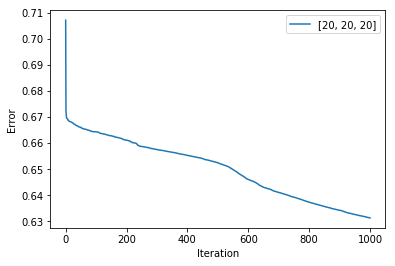

In [14]:
testLayerStructures(Xw5, Tc5, hiddenLayers, 1000)

### Error is still fairly high at 0.63, increase the number of layers and nodes at each layer as well as iterations

In [15]:
hiddenLayers2 = [[20, 20, 20], [20, 20, 20, 20], [40, 40, 40]]

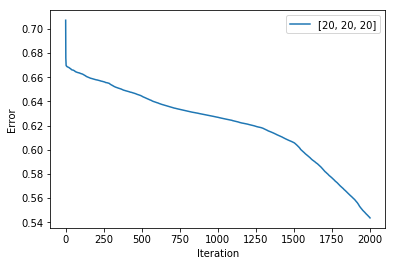

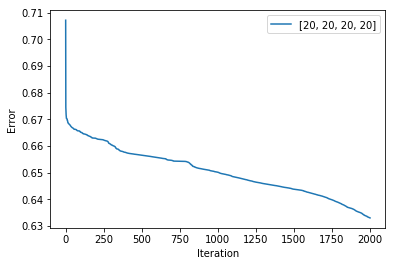

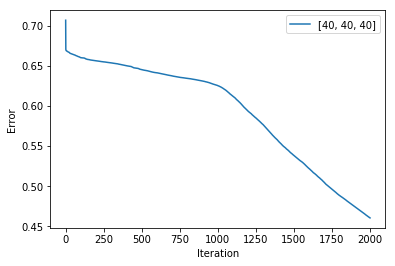

In [16]:
testLayerStructures(Xw5, Tc5, hiddenLayers2, 2000)

### We did a little better, lowering error to 0.45, try again with more nodes and iterations

In [17]:
hiddenLayers3 = [[80, 80, 80], [100, 100, 100], [80, 80, 80, 80]]

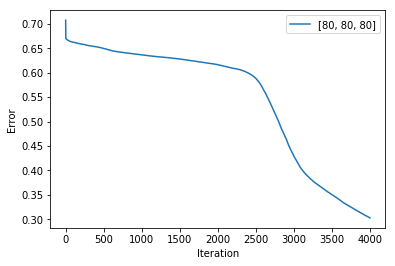

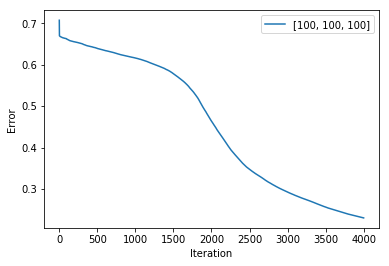

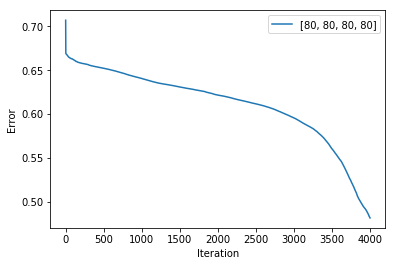

In [18]:
testLayerStructures(Xw5, Tc5, hiddenLayers3, 4000)

#### This code was run on both district 7 and district 5 (shown), error dips lowest on the [80, 80, 80, 80] network

In [19]:
results = trainNNs(Xw5, Tc5, 0.8, hiddenLayers3, 10, 4000)

In [20]:
summarize(results)

[[[80, 80, 80], 19.64902140982108, 135.03340113874918, 254.8680214881897],
 [[100, 100, 100], 16.47725607485594, 139.2608957250942, 353.53383231163025],
 [[80, 80, 80, 80], 38.7673870514549, 103.28985033156896, 351.2084581851959]]

In [21]:
bestNetwork(summarize(results))

[[80, 80, 80, 80], 38.7673870514549, 103.28985033156896, 351.2084581851959]

### Best NN so far (District 5 and 7), 3000/4000 iters, [80,80,80,80] , 3 weather inputs

In [23]:
classify = False

Xtrain, Ttrain, Xtest, Ttest = ml.partition(Xw5, Tc5, (0.8, 0.2), classify)


#training with 3000 iterations
nnet_3000 = nn.NeuralNetwork(Xw5.shape[1], [80,80,80,80], Tc5.shape[1])
nnet_3000.train(Xtrain, Ttrain, 3000)
           
Ytrain_3000 = nnet_3000.use(Xtrain)
Ytest_3000 = nnet_3000.use(Xtest)

#### Actual vs Predicted on District 5, Using 3 weather input [80, 80, 80,80], 3000 iters

DISTRICT 5
Hidden Layer Structure: [80,80,80,80] Number Iterations: 3000


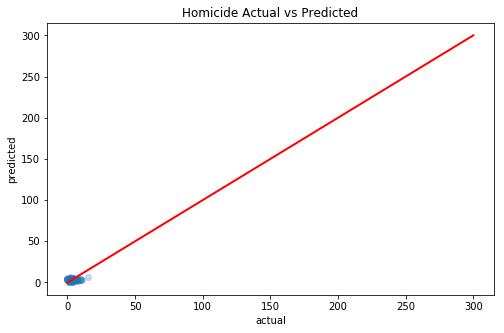

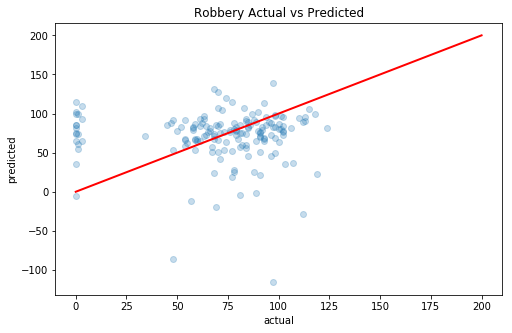

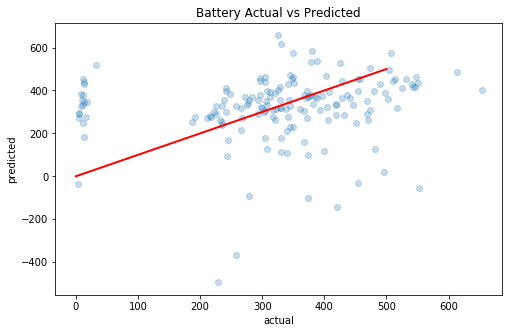

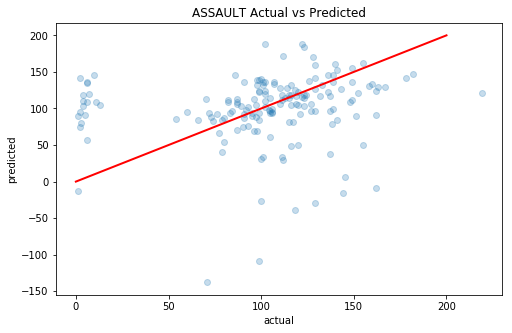

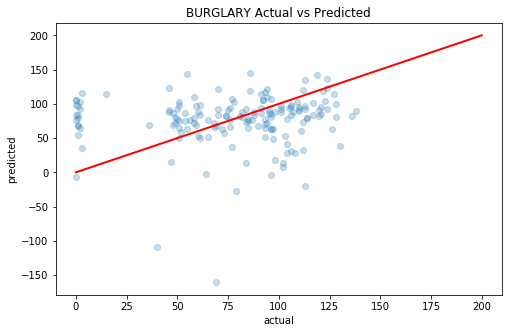

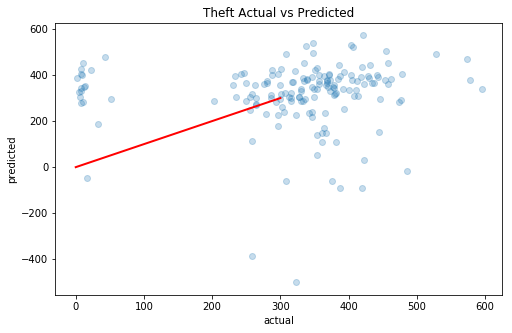

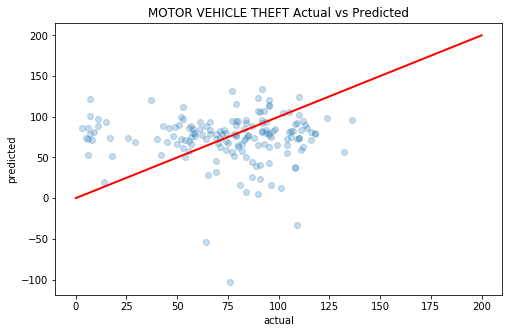

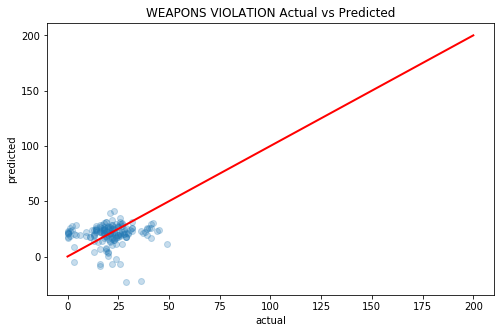

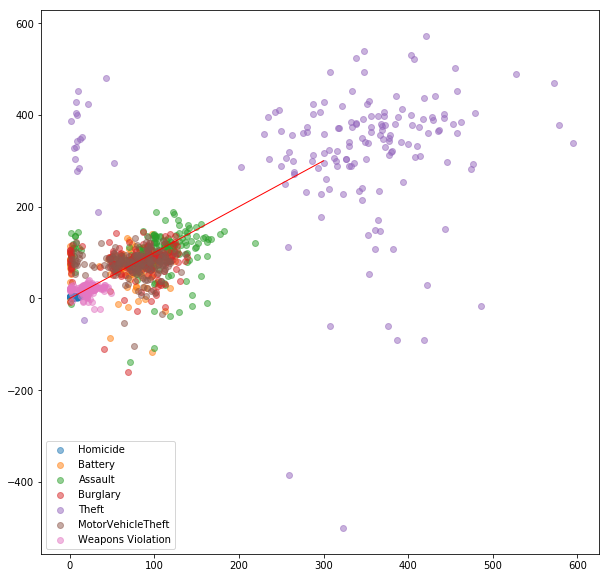

In [26]:
plotResults('5', '[80,80,80,80]', '3000' )

### Actual vs Predicted on District 1, Using only dry bulb/dew point, humidity weather input [80, 80,80], 3000 iters

In [27]:
Xw1, Tc1 = loadWeatherData("1.csv", 3)

In [28]:
classify = False

Xtrain, Ttrain, Xtest, Ttest = ml.partition(Xw1, Tc1, (0.8, 0.2), classify)


#training with 3000 iterations
nnet_3000 = nn.NeuralNetwork(Xw1.shape[1], [80,80,80,80], Tc1.shape[1])
nnet_3000.train(Xtrain, Ttrain, 3000)
           
Ytrain_3000 = nnet_3000.use(Xtrain)
Ytest_3000 = nnet_3000.use(Xtest)

DISTRICT 1
Hidden Layer Structure: [80,80,80,80] Number Iterations: 3000


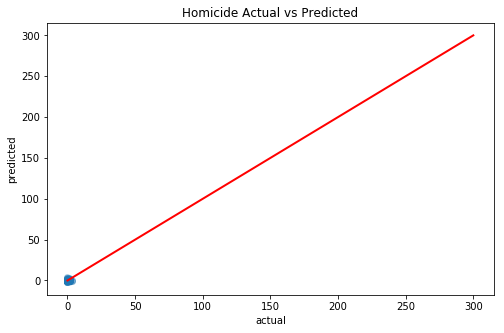

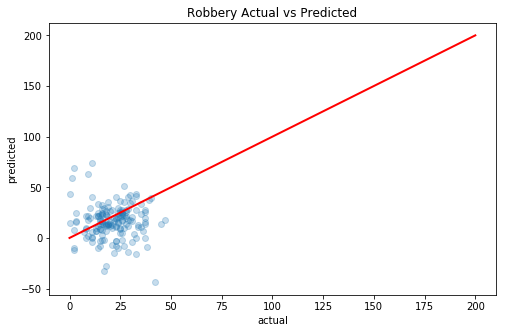

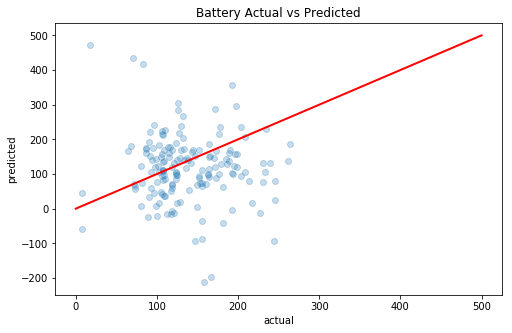

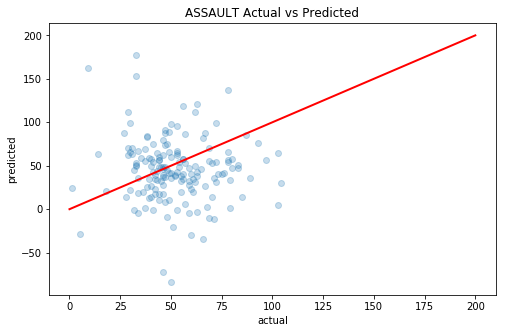

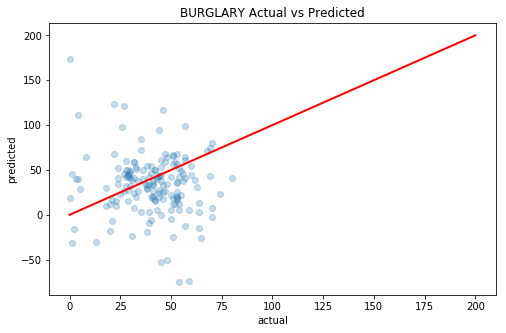

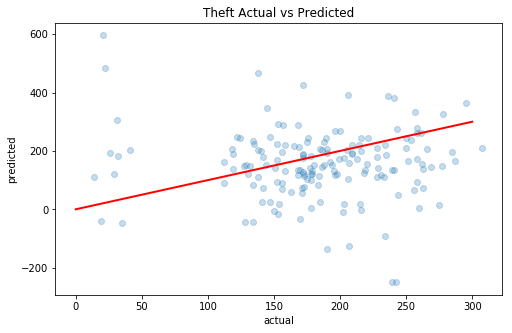

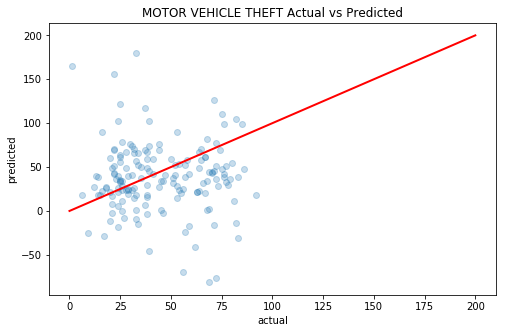

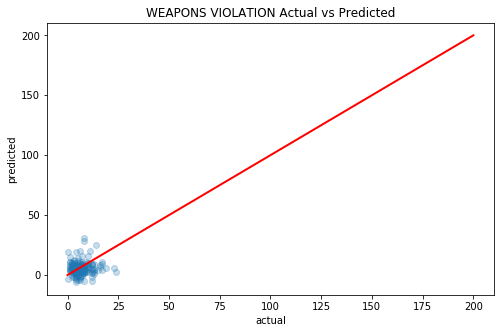

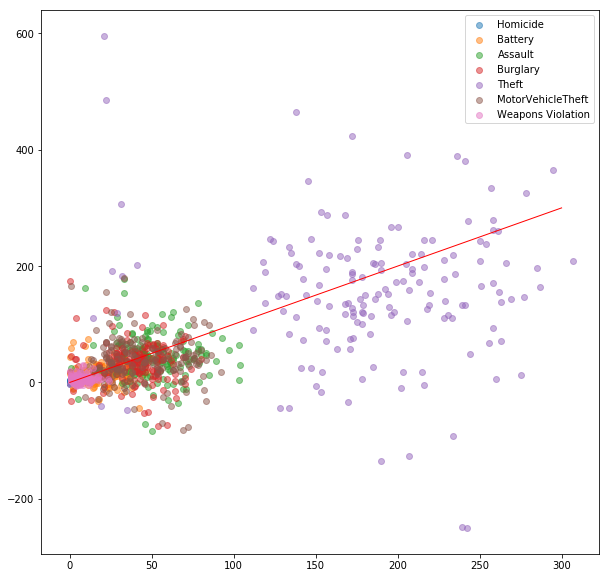

In [29]:
plotResults('1', '[80,80,80,80]', '3000' )

In [30]:
Xw2, Tc2 = loadWeatherData("2.csv", 3)

In [31]:
classify = False

Xtrain, Ttrain, Xtest, Ttest = ml.partition(Xw2, Tc2, (0.8, 0.2), classify)


#training with 3000 iterations
nnet_3000 = nn.NeuralNetwork(Xw2.shape[1], [80,80,80,80], Tc2.shape[1])
nnet_3000.train(Xtrain, Ttrain, 3000)
           
Ytrain_3000 = nnet_3000.use(Xtrain)
Ytest_3000 = nnet_3000.use(Xtest)

DISTRICT 2
Hidden Layer Structure: [80,80,80,80] Number Iterations: 3000


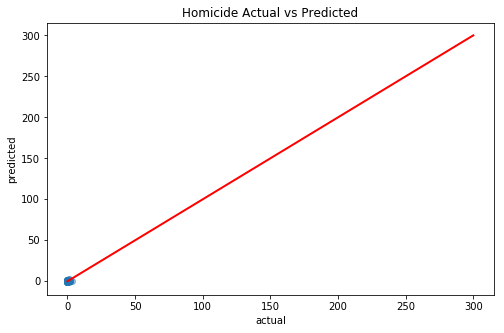

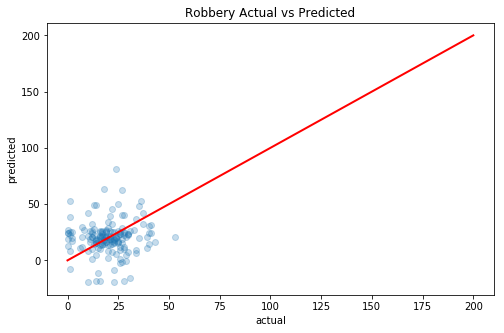

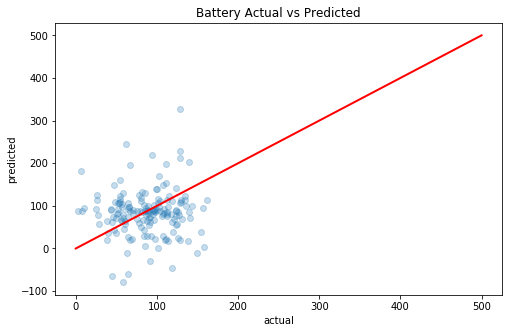

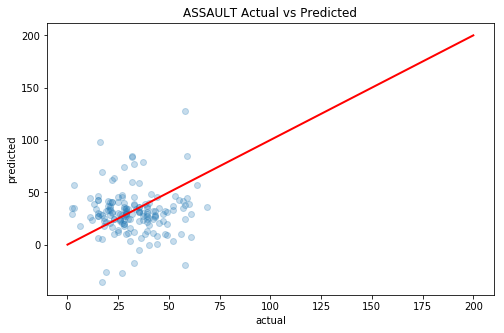

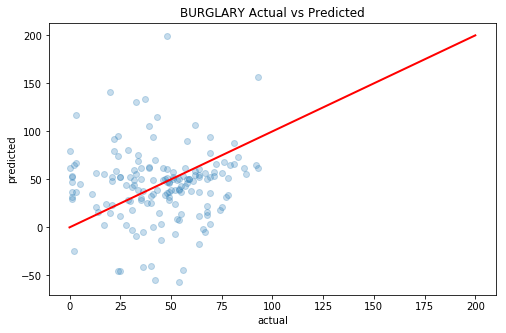

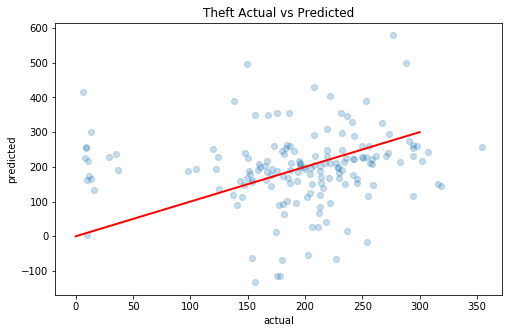

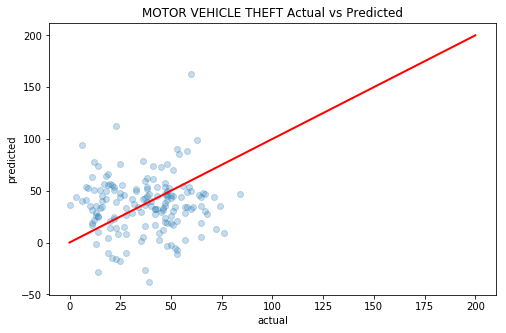

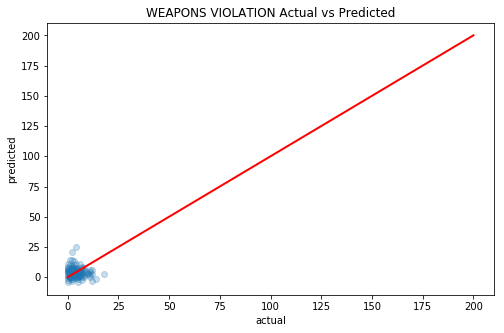

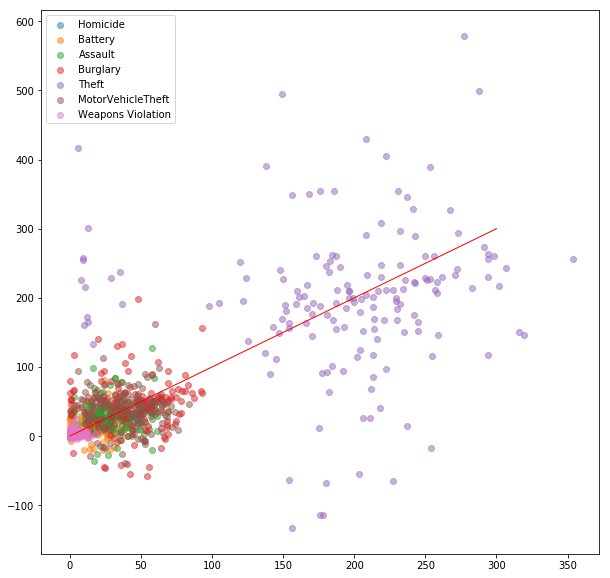

In [32]:
plotResults('2', '[80,80,80,80]', '3000' )

In [33]:
Xw3, Tc3 = loadWeatherData("3.csv", 3)

In [34]:
classify = False

Xtrain, Ttrain, Xtest, Ttest = ml.partition(Xw3, Tc3, (0.8, 0.2), classify)


#training with 3000 iterations
nnet_3000 = nn.NeuralNetwork(Xw3.shape[1], [80,80,80,80], Tc3.shape[1])
nnet_3000.train(Xtrain, Ttrain, 3000)
           
Ytrain_3000 = nnet_3000.use(Xtrain)
Ytest_3000 = nnet_3000.use(Xtest)

DISTRICT 3
Hidden Layer Structure: [80,80,80,80] Number Iterations: 3000


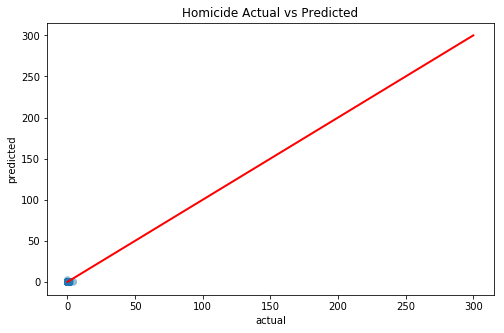

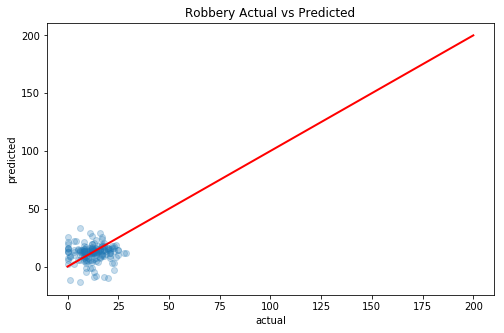

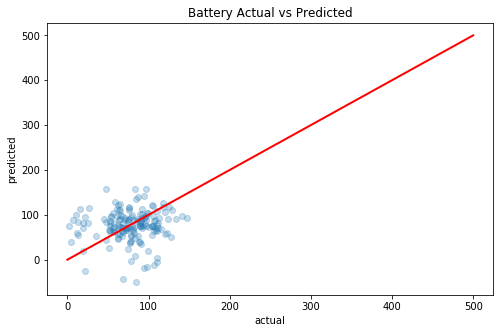

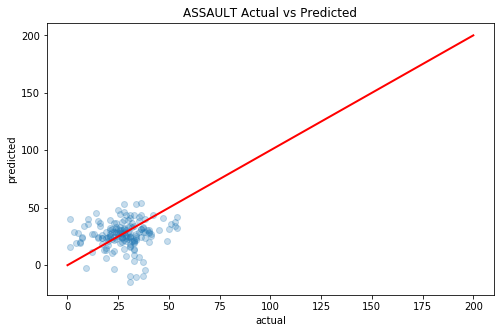

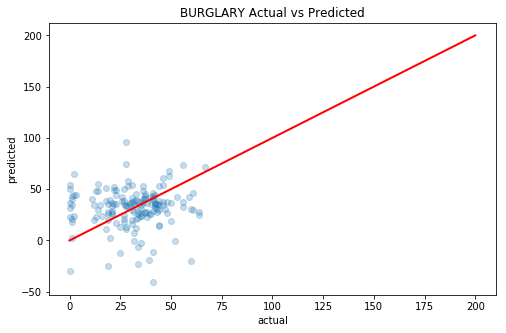

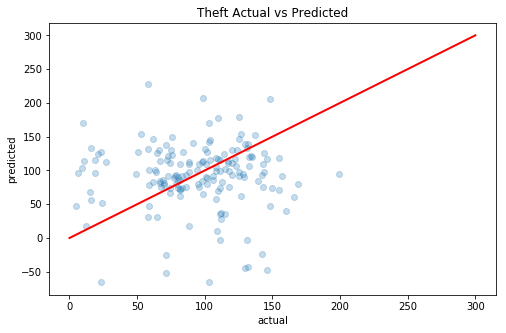

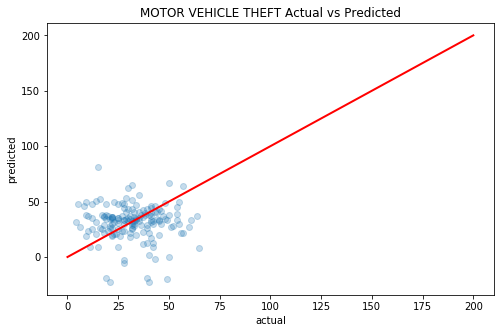

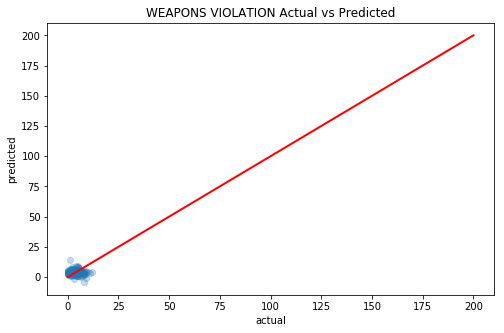

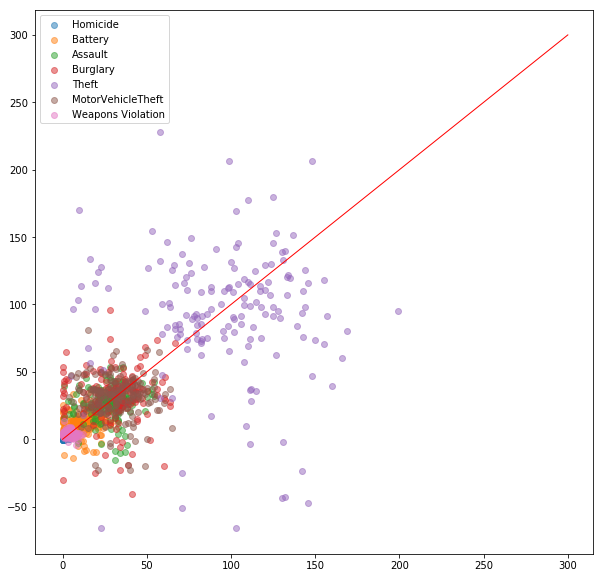

In [35]:
plotResults('3', '[80,80,80,80]', '3000' )

In [36]:
Xw4, Tc4 = loadWeatherData("4.csv", 3)

In [37]:
classify = False

Xtrain, Ttrain, Xtest, Ttest = ml.partition(Xw4, Tc4, (0.8, 0.2), classify)


#training with 3000 iterations
nnet_3000 = nn.NeuralNetwork(Xw4.shape[1], [80,80,80,80], Tc4.shape[1])
nnet_3000.train(Xtrain, Ttrain, 3000)
           
Ytrain_3000 = nnet_3000.use(Xtrain)
Ytest_3000 = nnet_3000.use(Xtest)

DISTRICT 4
Hidden Layer Structure: [80,80,80,80] Number Iterations: 3000


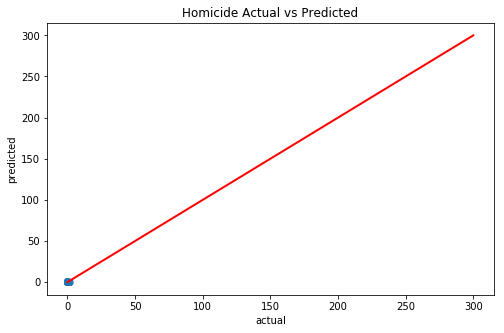

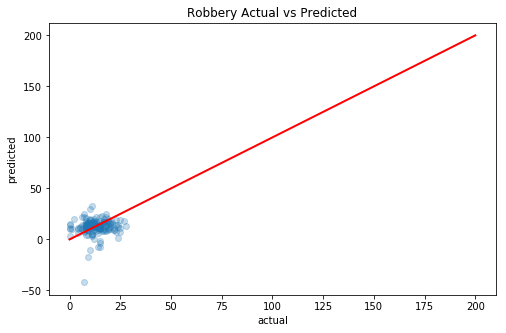

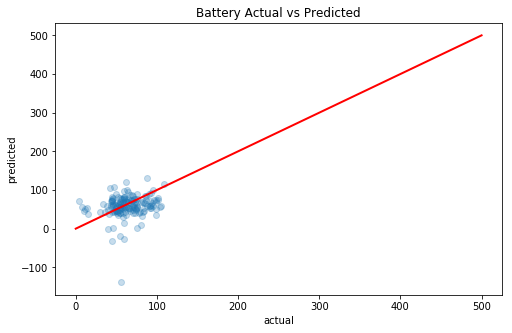

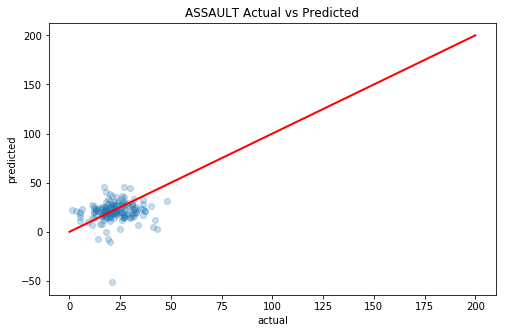

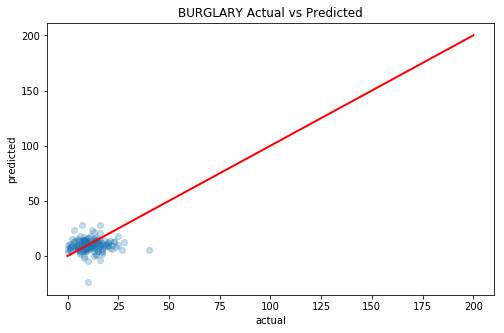

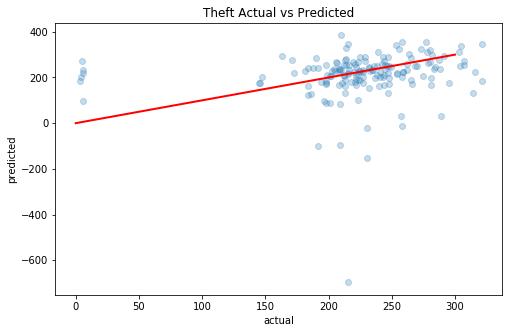

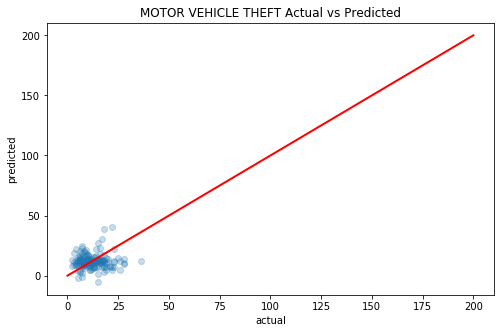

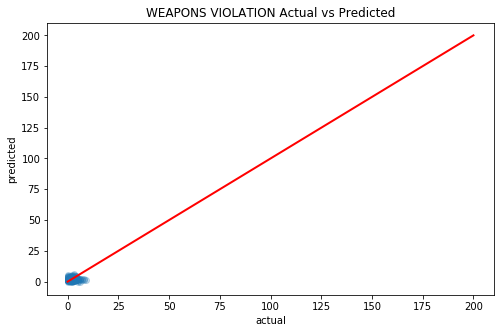

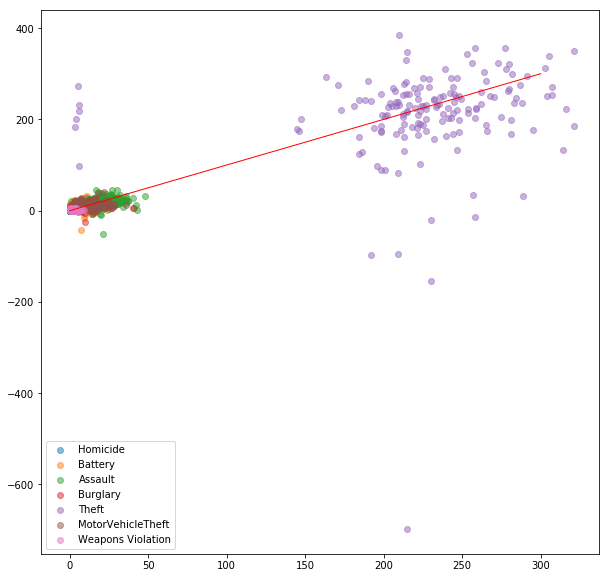

In [38]:
plotResults('4', '[80,80,80,80]', '3000' )

In [39]:
Xw6, Tc6 = loadWeatherData("6.csv", 3)

In [40]:
classify = False

Xtrain, Ttrain, Xtest, Ttest = ml.partition(Xw6, Tc6, (0.8, 0.2), classify)


#training with 3000 iterations
nnet_3000 = nn.NeuralNetwork(Xw6.shape[1], [80,80,80,80], Tc6.shape[1])
nnet_3000.train(Xtrain, Ttrain, 3000)
           
Ytrain_3000 = nnet_3000.use(Xtrain)
Ytest_3000 = nnet_3000.use(Xtest)

DISTRICT 6
Hidden Layer Structure: [80,80,80,80] Number Iterations: 3000


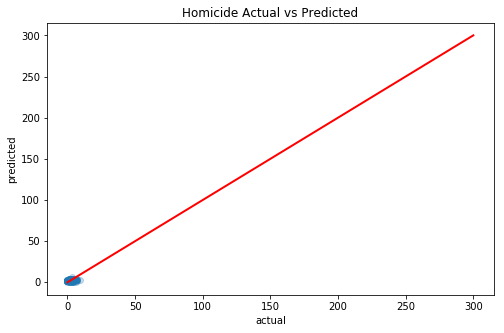

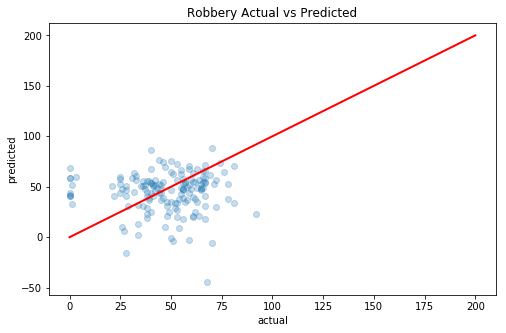

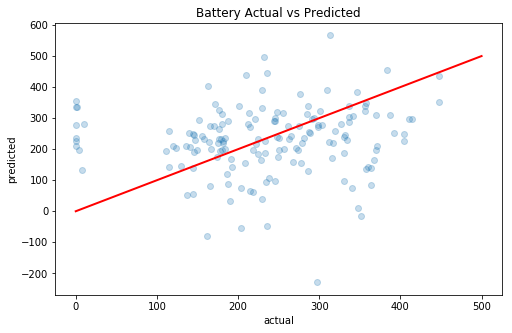

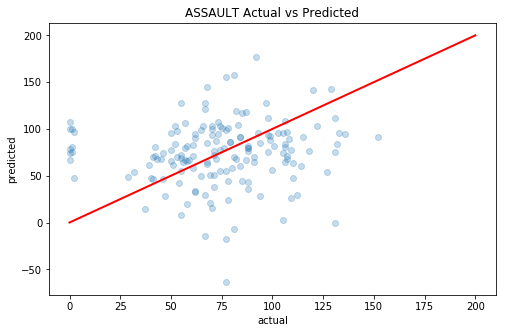

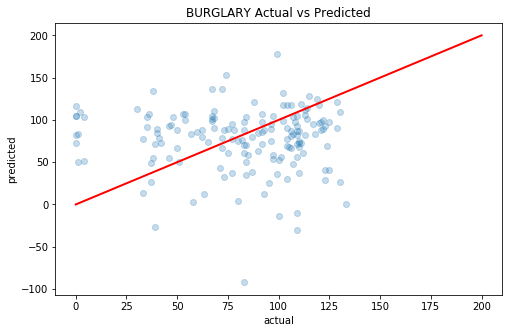

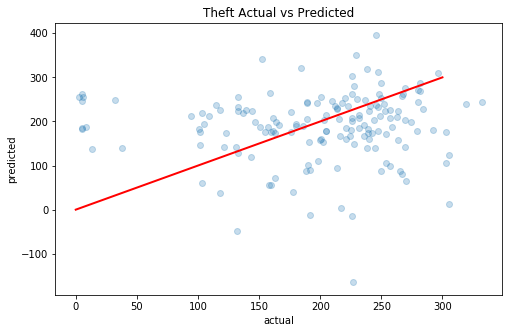

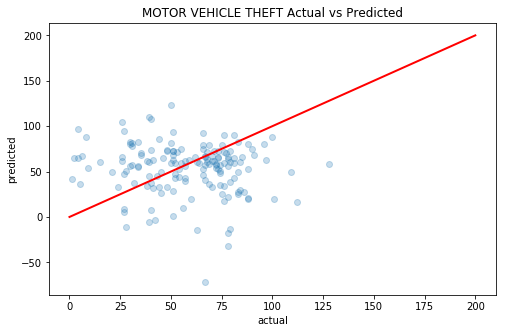

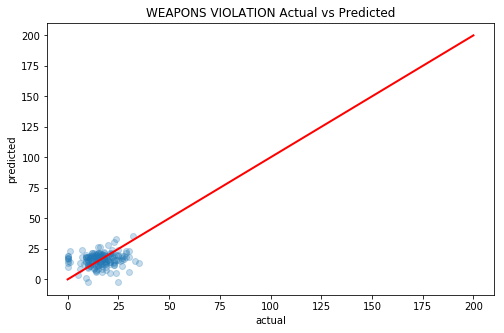

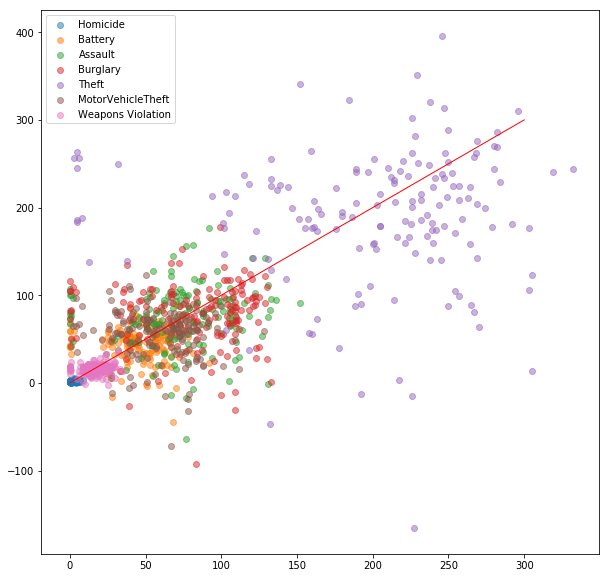

In [41]:
plotResults('6', '[80,80,80,80]', '3000' )

In [42]:
Xw7, Tc7 = loadWeatherData("7.csv", 3)

In [43]:
classify = False

Xtrain, Ttrain, Xtest, Ttest = ml.partition(Xw7, Tc7, (0.8, 0.2), classify)


#training with 3000 iterations
nnet_3000 = nn.NeuralNetwork(Xw7.shape[1], [80,80,80,80], Tc7.shape[1])
nnet_3000.train(Xtrain, Ttrain, 3000)
           
Ytrain_3000 = nnet_3000.use(Xtrain)
Ytest_3000 = nnet_3000.use(Xtest)

DISTRICT 7
Hidden Layer Structure: [80,80,80,80] Number Iterations: 3000


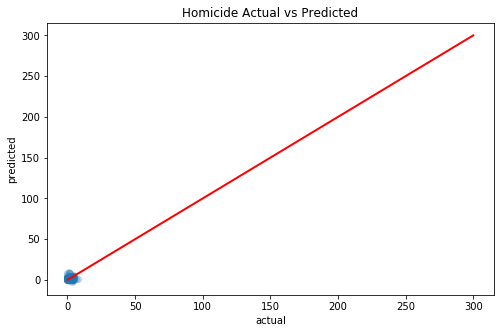

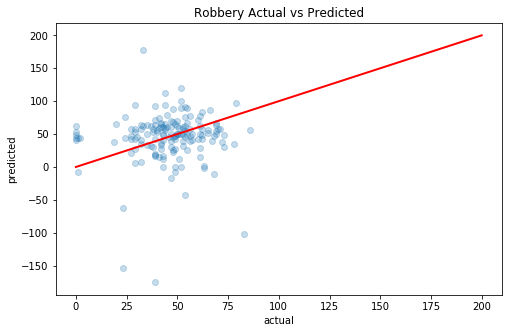

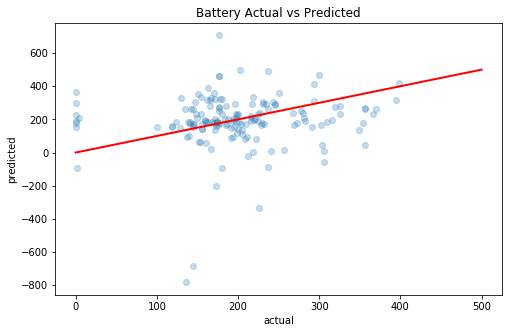

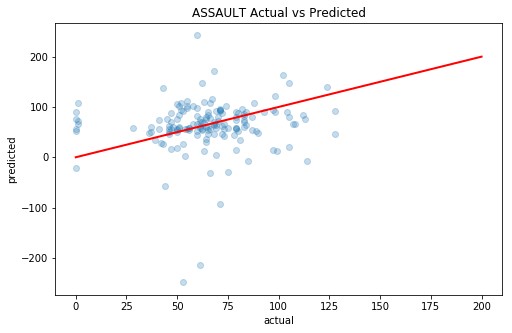

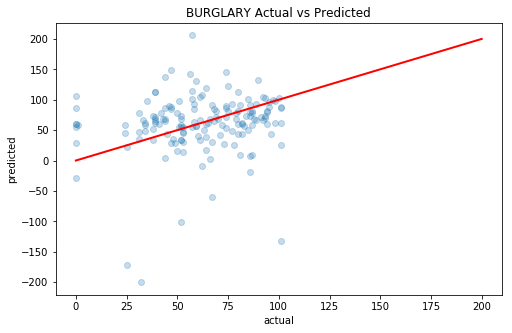

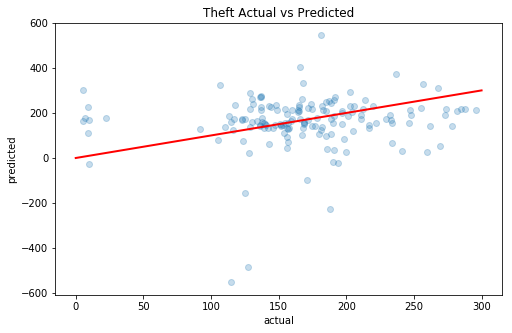

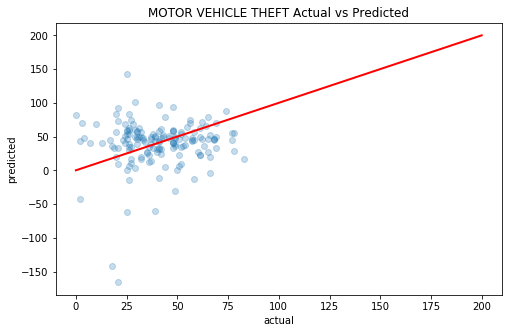

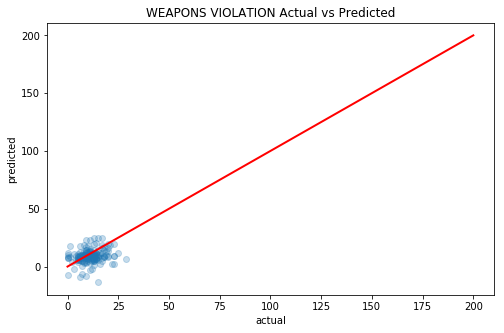

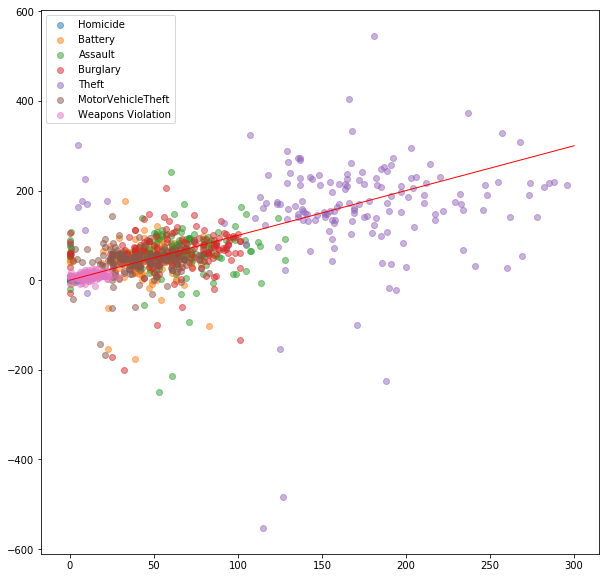

In [44]:
plotResults('7', '[80,80,80,80]', '3000' )

In [45]:
Xw8, Tc8 = loadWeatherData("8.csv", 3)

In [46]:
classify = False

Xtrain, Ttrain, Xtest, Ttest = ml.partition(Xw8, Tc8, (0.8, 0.2), classify)


#training with 3000 iterations
nnet_3000 = nn.NeuralNetwork(Xw8.shape[1], [80,80,80,80], Tc8.shape[1])
nnet_3000.train(Xtrain, Ttrain, 3000)
           
Ytrain_3000 = nnet_3000.use(Xtrain)
Ytest_3000 = nnet_3000.use(Xtest)

DISTRICT 8
Hidden Layer Structure: [80,80,80,80] Number Iterations: 3000


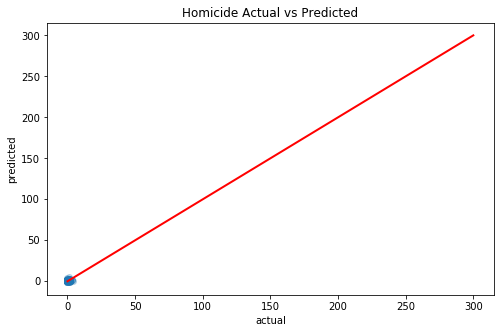

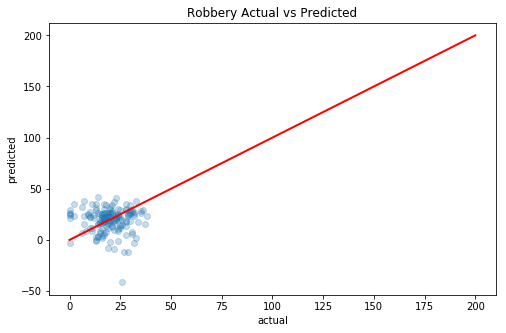

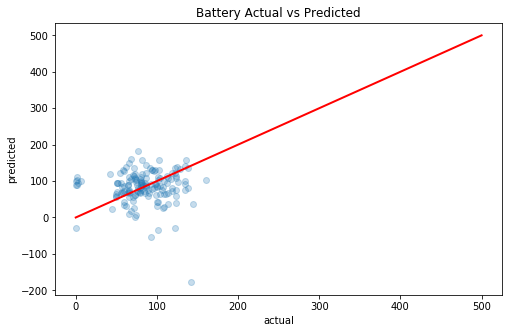

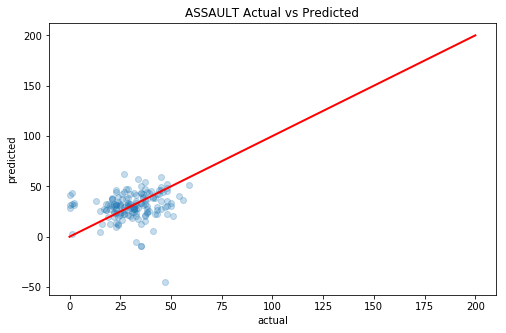

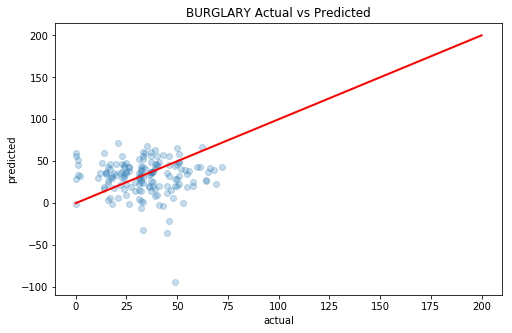

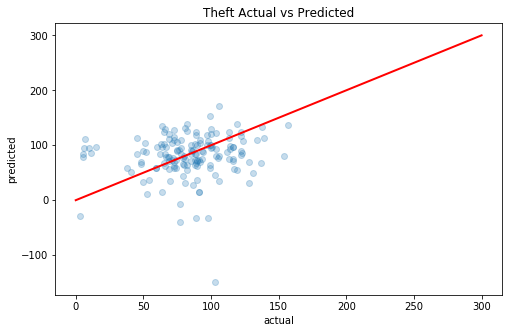

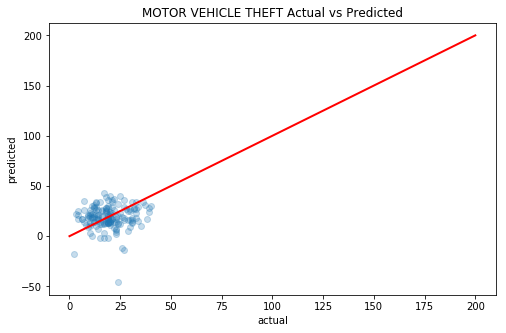

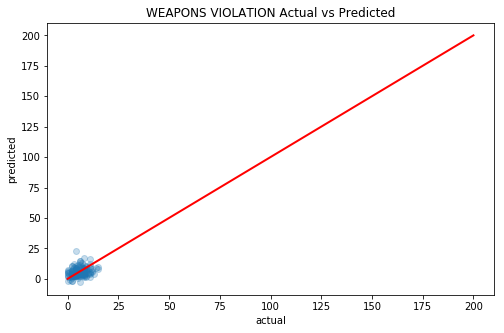

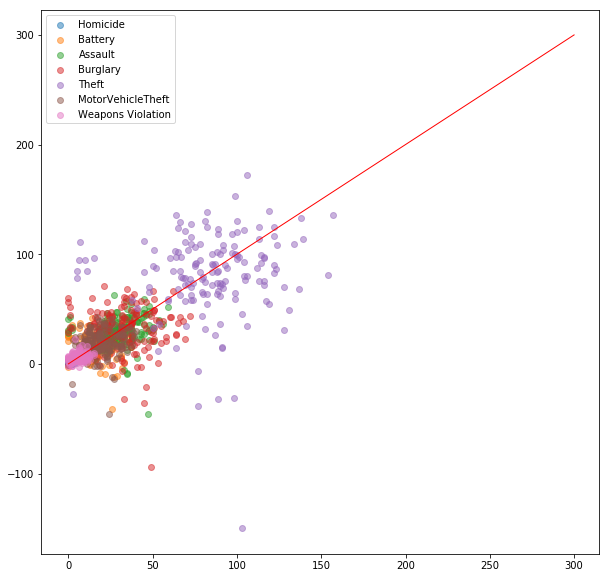

In [47]:
plotResults('8', '[80,80,80,80]', '3000' )

In [48]:
Xw9, Tc9 = loadWeatherData("9.csv", 3)

In [49]:
classify = False

Xtrain, Ttrain, Xtest, Ttest = ml.partition(Xw9, Tc9, (0.8, 0.2), classify)


#training with 3000 iterations
nnet_3000 = nn.NeuralNetwork(Xw9.shape[1], [80,80,80,80], Tc9.shape[1])
nnet_3000.train(Xtrain, Ttrain, 3000)
           
Ytrain_3000 = nnet_3000.use(Xtrain)
Ytest_3000 = nnet_3000.use(Xtest)

DISTRICT 9
Hidden Layer Structure: [80,80,80,80] Number Iterations: 3000


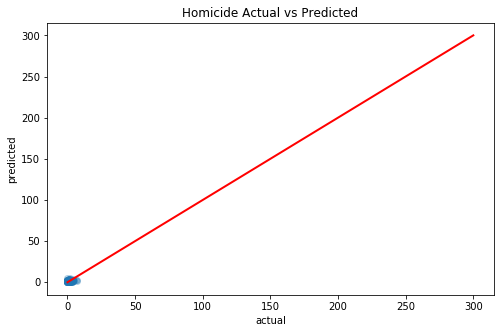

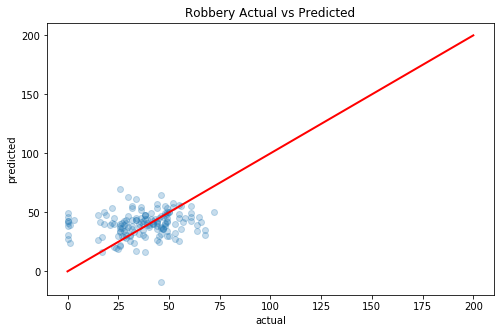

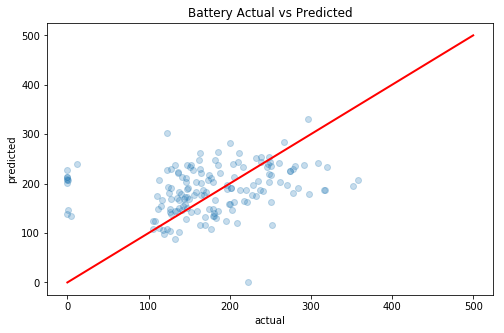

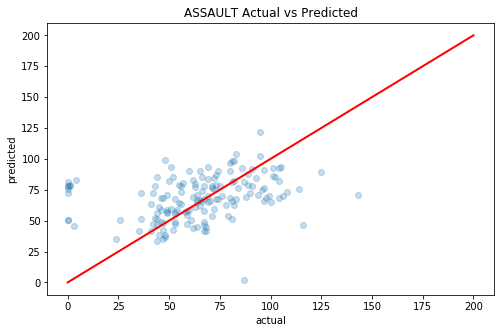

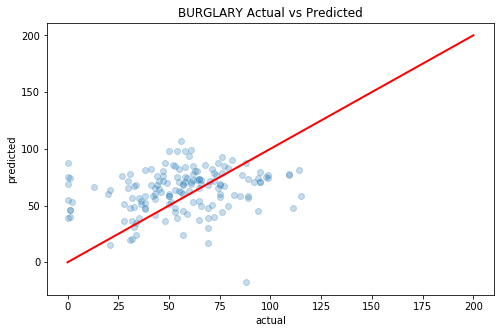

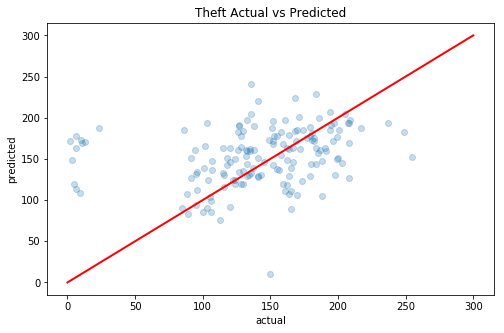

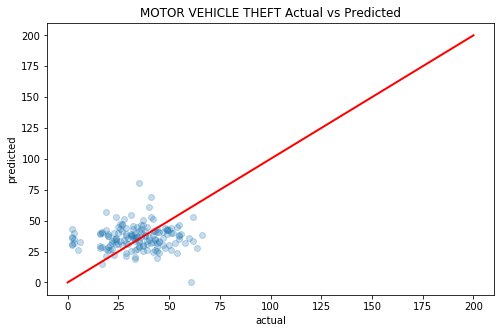

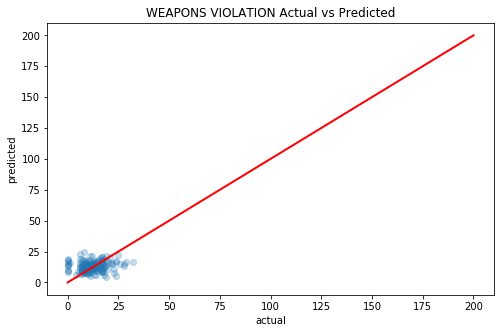

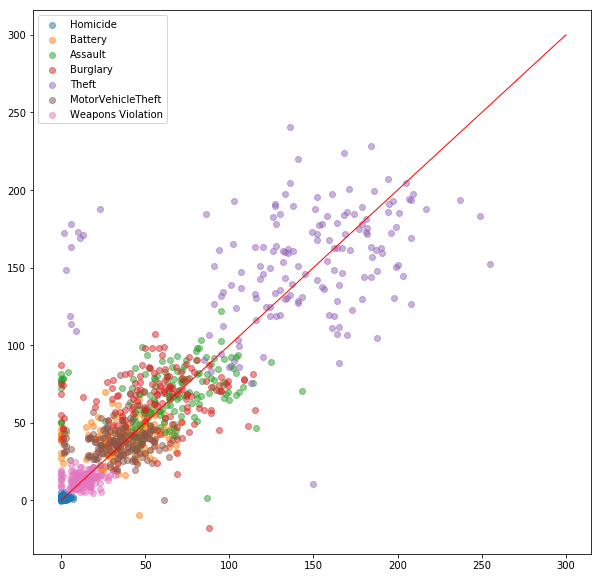

In [50]:
plotResults('9', '[80,80,80,80]', '3000' )